# Lab | Random Forests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
targets = pd.read_csv('./files_for_lab/target.csv')
categorical = pd.read_csv('./files_for_lab/categorical.csv')
numerical = pd.read_csv('./files_for_lab/numerical.csv')

In [3]:
print(targets.shape)
print(categorical.shape)
print(numerical.shape)

(95412, 2)
(95412, 22)
(95412, 315)


In [4]:
print(targets.isna().sum().sum())
print(categorical.isna().sum().sum())
print(numerical.isna().sum().sum())

0
0
0


In [5]:
targets

,TARGET_B,TARGET_D
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
95407,0,0.0
95408,0,0.0
95409,0,0.0
95410,1,18.0


In [6]:
# numerical

We drop TCODE, DOB, ADI, DMA, MSA and CONTROLN (it is a unique record identifier).

In [7]:
numerical = numerical.drop(['TCODE', 'ADI', 'DMA', 'MSA', 'CONTROLN'], axis=1)  

RFA_2F, CLUSTER2 will be included as categorical.

In [8]:
categorical['RFA_2F'] = numerical['RFA_2F']

In [9]:
categorical['CLUSTER2'] = numerical['CLUSTER2']

In [10]:
numerical = numerical.drop(['RFA_2F', 'CLUSTER2'], axis=1)

Income, wealth1 and wealth2 are categories but can be treated with the scaler as numerical.

In [11]:
categorical = categorical.astype(str)

### Train-test split.

In [12]:
X = pd.concat([categorical, numerical], axis=1)

In [13]:
X.shape

(95412, 332)

In [14]:
y = targets.drop('TARGET_D', axis=1)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Oversampling.

In [16]:
df_train = pd.concat([X_train, y_train], axis=1)

In [17]:
df_train_1 = df_train[df_train['TARGET_B']==1]
df_train_0 = df_train[df_train['TARGET_B']==0]

In [18]:
print(len(df_train_1))
len(df_train_0)

3619


67940

In [19]:
from sklearn.utils import resample
df_train_1_ov = resample(df_train_1, replace=True, n_samples = len(df_train_0))

In [20]:
print(len(df_train_1_ov))
len(df_train_0)

67940


67940

In [21]:
df_train_ov = pd.concat([df_train_1_ov, df_train_0], axis=0).reset_index(drop=True)

In [22]:
X_train_ov = df_train_ov.drop('TARGET_B', axis=1)
y_train_ov = df_train_ov['TARGET_B']

In [23]:
X_train_ov.isna().sum().sum()

0

In [24]:
y_train_ov.isna().sum().sum()

0

### Encoding.

Train.

In [25]:
X_train_ov_num = X_train_ov.select_dtypes(exclude=object)
X_train_ov_cat = X_train_ov.select_dtypes(include=object)

In [26]:
# X_train_ov_num

In [27]:
# X_train_ov_cat

In [28]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train_ov_cat)

In [29]:
X_train_cat_encoded = encoder.transform(X_train_ov_cat).toarray()

In [30]:
feature_names = encoder.get_feature_names_out(input_features=X_train_ov_cat.columns)

X_train_cat_enc = pd.DataFrame(X_train_cat_encoded, columns=feature_names)

In [31]:
# X_train_cat_enc

Test.

In [32]:
X_test_num = X_test.select_dtypes(exclude=object)
X_test_cat = X_test.select_dtypes(include=object)

In [33]:
X_test_cat_encoded = encoder.transform(X_test_cat).toarray()

c:\Users\dcast\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [10, 12, 16, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [34]:
feature_names = encoder.get_feature_names_out(input_features=X_test_cat.columns)

X_test_cat_enc = pd.DataFrame(X_test_cat_encoded, columns=feature_names)

In [35]:
# X_test_cat_enc

### Scaling.

Train.

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

In [37]:
scaler.fit(X_train_ov_num)

MinMaxScaler()

In [38]:
X_train_num_sc = pd.DataFrame(scaler.transform(X_train_ov_num), columns=X_train_ov_num.columns)

In [39]:
# X_train_num_sc

Test.

In [40]:
X_test_num_sc = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

In [41]:
# X_test_num_sc

### Concat.

In [42]:
X_train_tr = pd.concat([X_train_num_sc, X_train_cat_enc], axis=1)

In [43]:
X_train_tr.isna().sum().sum()

0

In [44]:
X_test_tr = pd.concat([X_test_num_sc, X_test_cat_enc], axis=1)

In [45]:
X_test_tr.isna().sum().sum()

0

In [46]:
df_train_tr = pd.concat([X_train_tr, y_train_ov], axis=1)

In [47]:
df_train_tr.isna().sum().sum()

0

In [48]:
y_test = y_test.reset_index(drop=True)

In [49]:
df_test_tr = pd.concat([X_test_tr, y_test], axis=1)

In [50]:
df_test_tr.isna().sum().sum()

0

### Random forest (1).

In [51]:
X_train = df_train_tr.drop('TARGET_B', axis=1)
y_train = df_train_tr['TARGET_B']

In [52]:
X_test = df_test_tr.drop('TARGET_B', axis=1)
y_test = df_test_tr['TARGET_B']

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(max_depth=5,
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8,
                             )
rf1.fit(X_train, y_train)
print(rf1.score(X_train, y_train))
print(rf1.score(X_test, y_test))

0.6230718280836032
0.5981218295392613


In [54]:
from sklearn.metrics import confusion_matrix
y_pred = rf1.predict(X_test)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0    22629
1     1224
Name: TARGET_B, dtype: int64

array([[13591,  9038],
       [  548,   676]], dtype=int64)

In [55]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("precision: ",precision_score(y_test,y_pred))
print("recall: ",recall_score(y_test,y_pred))
print("f1: ",f1_score(y_test,y_pred))

precision:  0.06959028206711962
recall:  0.5522875816993464
f1:  0.12360577802157617


### Feature selection (Selectkbest).

In [56]:
X = df_train_tr.drop('TARGET_B', axis=1)
y = df_train_tr['TARGET_B']

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
kbest = SelectKBest(chi2, k=10).fit(X, y)

In [57]:
df =pd.DataFrame(data = kbest.scores_, columns = ['score'])
df['Column'] = X.columns
print(df.sort_values(by = ['score'], ascending = False))

            score        Column
624  1.384827e+03      RFA_2F_4
400  7.893009e+02  ODATEW_YR_96
378  7.413970e+02      RFA_2A_G
376  5.998691e+02      RFA_2A_E
623  4.465697e+02      RFA_2F_3
..            ...           ...
56   1.028977e-03        CHILC4
48   4.160396e-04         AGEC3
88   3.967733e-04           HU3
27   6.925111e-29          ETH8
650  0.000000e+00   CLUSTER2_33

[686 rows x 2 columns]


In [58]:
cols = df.sort_values(by = ['score'], ascending = False).head(30)['Column']
type(cols)

pandas.core.series.Series

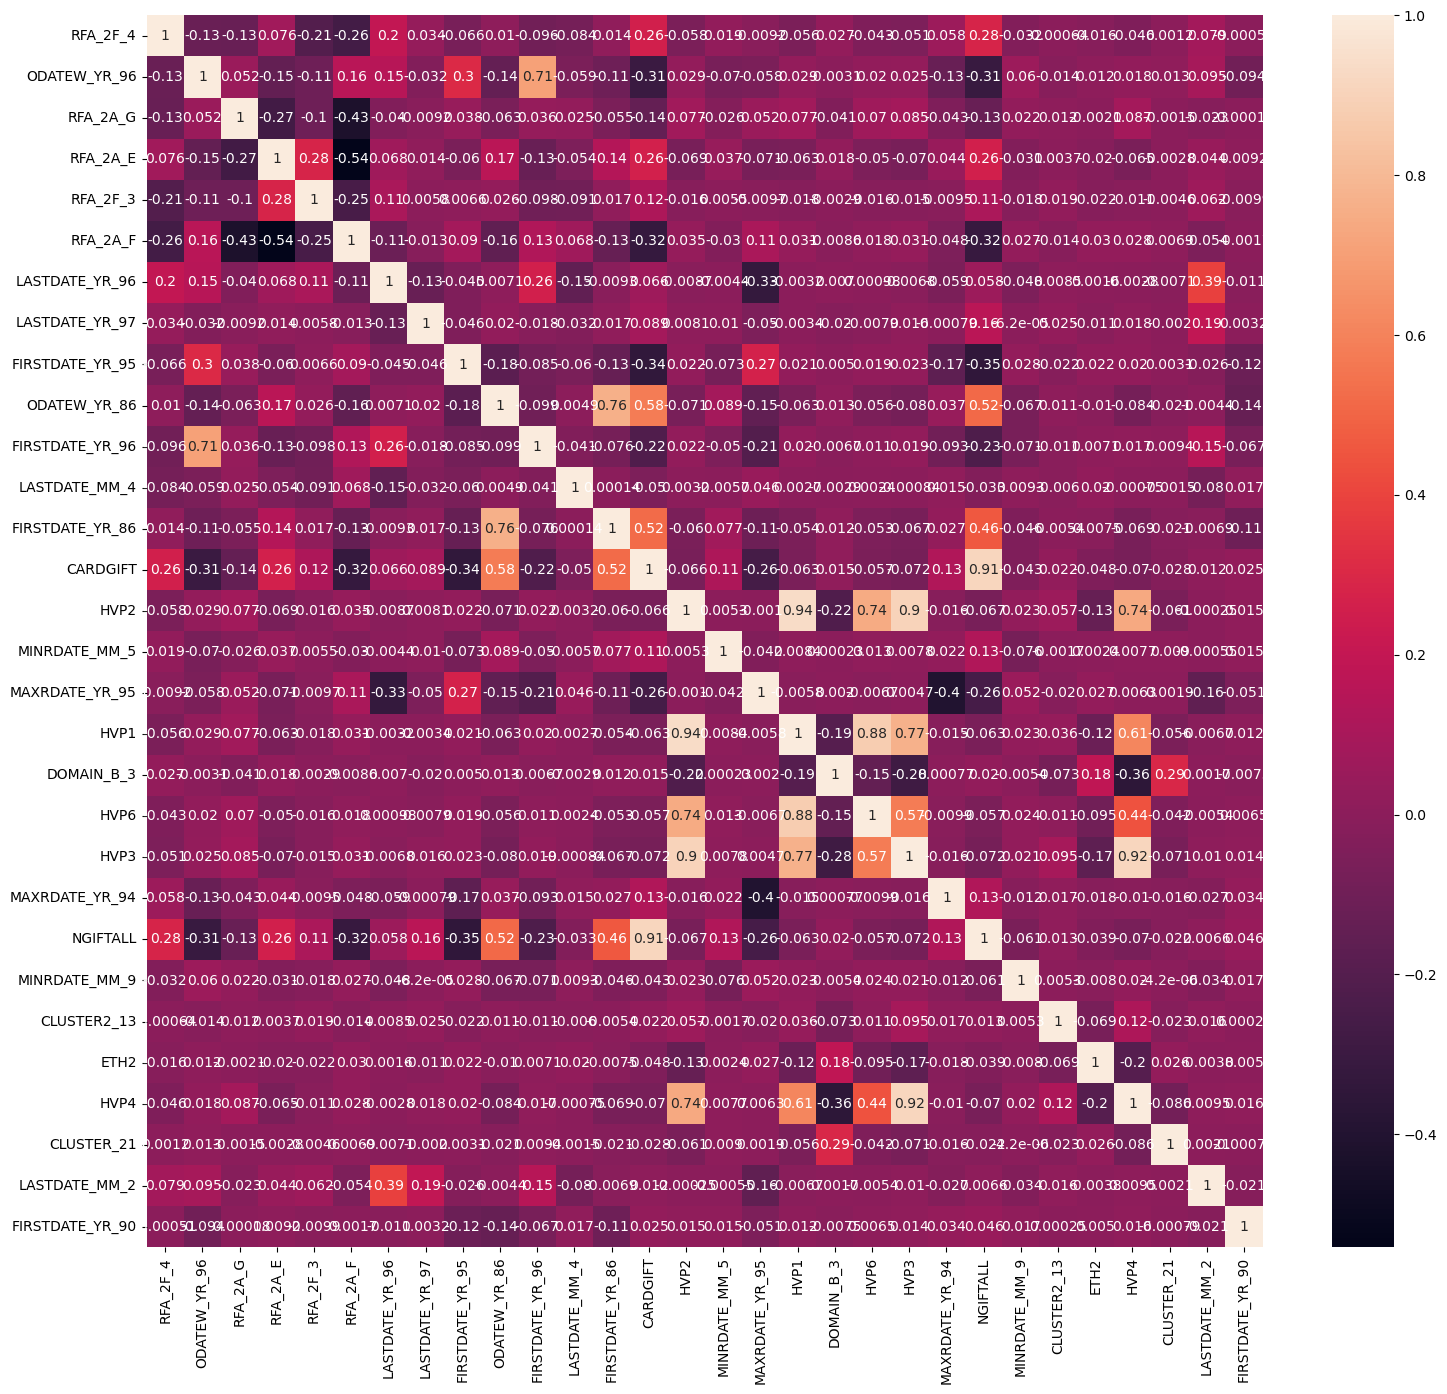

In [59]:
corr_matrix=X[cols].corr()
fig, ax = plt.subplots(figsize=(18,16))
ax = sns.heatmap(corr_matrix, annot=True)

### Random forest (2).

In [60]:
X_train_2 = X_train[cols]
# X_train_2

In [61]:
X_test_2 = X_test[cols]
# X_test_2

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(max_depth=5,
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8,
                             )
rf2.fit(X_train_2, y_train)
print(rf2.score(X_train_2, y_train))
print(rf2.score(X_test_2, y_test))

0.6054459817486018
0.5675177126566889


In [63]:
from sklearn.metrics import confusion_matrix
y_pred_2 = rf2.predict(X_test_2)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred_2))

0    22629
1     1224
Name: TARGET_B, dtype: int64

array([[12819,  9810],
       [  506,   718]], dtype=int64)

In [64]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("precision: ",precision_score(y_test,y_pred_2))
print("recall: ",recall_score(y_test,y_pred_2))
print("f1: ",f1_score(y_test,y_pred_2))

precision:  0.06819908814589666
recall:  0.5866013071895425
f1:  0.12219196732471069


Discuss the output and its impact in the business scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the business?

Both models offer an similar f1 score (which takes into acocunt both precision and recall). In this case, we are interested in both metrics.